In [3]:
from create_model import get_model
from dataset import load_data
from train_model import collate_fn
from visualization import drawrect
from torchvision.ops import nms
from transformations import get_transformation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [7]:
asd = torch.rand(3,4)*100
print(asd)
asd_int = asd.to(dtype=int)
print(asd_int)

tensor([[78.1376, 53.9621, 46.5650, 61.2599],
        [91.7575, 20.7093, 11.4936, 26.1333],
        [99.1476, 98.2276, 26.4622,  7.9748]])
tensor([[78, 53, 46, 61],
        [91, 20, 11, 26],
        [99, 98, 26,  7]])


In [ ]:
# Load Model
model = get_model("fasterrcnn", num_classes=4, trainable_backbone_layers=1)
model_path = "G:/My Drive/ACV Project/m_v3_50e.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()

In [4]:
# Load dataset
dataset_path = "./../../NBA-Player-Detector-1"
transformation = get_transformation()
trainset, valset, testset = load_data(dataset_path, train_transform=transformation)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=2, 
                                          shuffle=False, 
                                          num_workers=1, 
                                          drop_last=False,
                                          collate_fn = collate_fn)

In [5]:
image, targets = trainset[0]



Boxes are:
tensor([[4.0300e+02, 1.0000e+00, 5.9300e+02, 2.1100e+02],
        [5.8800e+02, 2.6900e+02, 7.6900e+02, 5.6400e+02],
        [6.2900e+02, 1.9600e+02, 7.8900e+02, 4.7900e+02],
        [8.8100e+02, 2.9300e+02, 1.0730e+03, 5.5100e+02],
        [1.1060e+03, 1.2800e+02, 1.2540e+03, 3.8900e+02],
        [1.1010e+03, 5.0100e+02, 1.2790e+03, 8.8400e+02],
        [9.2600e+02, 4.6100e+02, 1.1140e+03, 8.5400e+02],
        [7.6300e+02, 4.0300e+02, 8.9800e+02, 7.5100e+02],
        [7.4800e+02, 3.9800e+02, 9.6900e+02, 6.6100e+02],
        [6.2300e+02, 3.5100e+02, 7.9300e+02, 6.9400e+02],
        [3.2900e+02, 6.6900e+02, 4.7900e+02, 9.9300e+02],
        [6.0100e+02, 3.4300e+02, 6.4300e+02, 3.9800e+02]])


ValueError: Expected y_max for bbox (tensor(0.3731), tensor(0.3333), tensor(0.5491), tensor(70.3333), tensor(3)) to be in the range [0.0, 1.0], got 70.33333587646484.

In [3]:
for i,(images, labels) in enumerate(trainloader):
    N = len(images)
    for j in range(N):
        image = images[j]       # (C, H, W) tensor float
        label = labels[j]       # dict with keys 'boxes', 'labels'        
    if i==1:
        break

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\zente\Github\NBA-Detector\src\nba_detector\dataset.py", line 119, in __getitem__
    transformed = self.transform(image=image_np, bboxes=targets["boxes"], bounding_box_labels=targets['labels'])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\composition.py", line 202, in __call__
    p.preprocess(data)
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\utils.py", line 83, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\utils.py", line 91, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\bbox_utils.py", line 124, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\bbox_utils.py", line 390, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\bbox_utils.py", line 390, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\bbox_utils.py", line 334, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "c:\Users\zente\anaconda3\envs\nba2\Lib\site-packages\albumentations\core\bbox_utils.py", line 417, in check_bbox
    raise ValueError(f"Expected {name} for bbox {bbox} to be in the range [0.0, 1.0], got {value}.")
ValueError: Expected y_max for bbox (tensor(0.3731), tensor(0.3333), tensor(0.5491), tensor(70.3333), tensor(3)) to be in the range [0.0, 1.0], got 70.33333587646484.


In [8]:
image = images[0]       # (C, H, W) tensor float
label = labels[0]

(-0.5, 1919.5, 1079.5, -0.5)

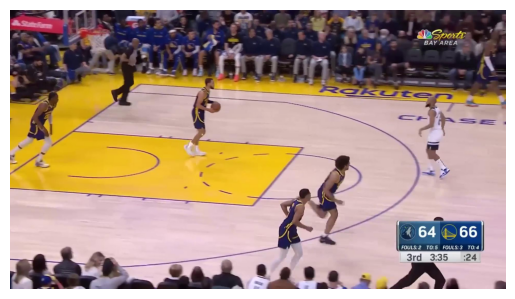

In [11]:
vis_image = (image * 255).to(torch.uint8)
vis_image = vis_image.permute(1,2,0).numpy()
plt.imshow(vis_image)
plt.axis('off')

In [9]:
a = np.zeros((3,10,20))
print(a.shape)
a = np.transpose(a, (1,2,0))
print(a.shape)

(3, 10, 20)
(10, 20, 3)


In [8]:
for (images, labels) in trainloader:
    predictions = model(images)
    N = len(images)
    for i in range(N):
        image = images[i]       # (C, H, W) tensor float
        label = labels[i]       # dict with keys 'boxes', 'labels'
        pred = predictions[i]   # dict with keys 'boxes', 'labels', 'scores'
    break

In [22]:
CLASS_COLORS = {
    1 : (255,0,0),
    2 : (0,255,0),
    3 : (0,0,255)
}

def draw_gt_pred_boxes(image: torch.Tensor, gt: torch.Tensor, pred: torch.Tensor, MIN_PRED_SCORE=0.5):
    """

    Args:
        image (torch.Tensor): torch.float32 shape (C x H x W)
        gt (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (N, 4)
            - 'labels' -> Tensor of shape (N, ) with ints
        pred (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (M, 4)
            - 'labels' -> Tensor of shape (M, ) with ints
            - 'scores' -> Tensor of shape (M, ) with floats
    """

    assert image.dtype == torch.float32
    assert type(gt) == dict
    assert type(pred) == dict

    # Transform image to numpy array of ints and shape (H,W,C)
    vis_image = (image * 255).to(torch.uint8)
    vis_image = vis_image.permute(1,2,0).numpy()

    # Define the list of gt and pred to process
    # TODO check if to apply NMS here
    
    # Predicted boxes
    pred_indices = [i for i in range(len(pred['boxes'])) if pred['scores'][i] >= MIN_PRED_SCORE]
    pred_boxes = [pred['boxes'][i] for i in pred_indices]
    pred_labels = [pred['labels'][i] for i in pred_indices]
    
    # Ground truth
    gt_boxes = gt['boxes'].detach().clone().tolist()
    gt_labels = gt['labels'].detach().clone().tolist()

    # Draw predicted boxes
    for i in pred_indices:
        x_min, y_min, x_max, y_max = pred_boxes[i]
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        label_id = pred_labels[i].item()
        color = CLASS_COLORS[label_id]
        drawrect(vis_image, point1, point2, color, thickness=4, style='dotted')
    
    # Draw ground truth boxes
    for i in range(len(gt_boxes)):
        x_min, y_min, x_max, y_max = gt_boxes[i]
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        label_id = gt_labels[i]
        color = CLASS_COLORS[label_id]
        vis_image = cv2.rectangle(vis_image, point1, point2, color, thickness=4)
    
    return vis_image

In [23]:
vis_image = draw_gt_pred_boxes(image, label, pred)

(-0.5, 1919.5, 1079.5, -0.5)

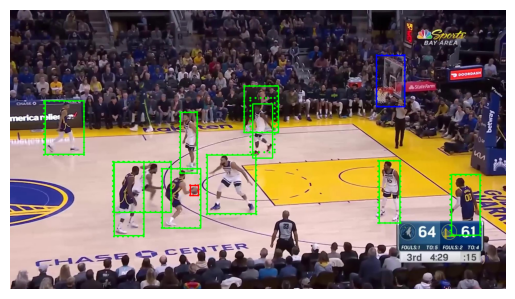

In [24]:
plt.imshow(vis_image)
plt.axis('off')